In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [5]:
df = pd.read_csv('/content/drive/MyDrive/UU/BNB-USD (BaoCao).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


In [72]:

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [74]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [76]:
# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920 non-null   float64
 2   Low        1920 non-null   float64
 3   Close      1920 non-null   float64
 4   Adj Close  1920 non-null   float64
 5   Volume     1920 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.0 KB


In [79]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Correct the column name 'Adj Close'
df = df[cols]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def calculate_vif(df):
    """Calculate Variance Inflation Factor (VIF) for each variable."""
    vif_df = pd.DataFrame()
    vif_df["variables"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

def cointegration_test(df, alpha=0.05, max_vif=10):
    """Perform Johanson's Cointegration Test and Report Summary"""
    # Convert numeric columns to float
    df_numeric = df.select_dtypes(include=['number']).astype(float)

    # Drop any columns with all zero values
    df_numeric = df_numeric.loc[:, (df_numeric != 0).any(axis=0)]

    # Drop constant columns to handle perfect multicollinearity
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()]

    # Calculate VIF and drop columns with VIF higher than the threshold
    while True:
        vif_df = calculate_vif(df_numeric)
        max_vif_value = vif_df['VIF'].max()
        if max_vif_value > max_vif:
            remove_col = vif_df.sort_values('VIF', ascending=False)['variables'].iloc[0]
            print(f"Removing {remove_col} with VIF {max_vif_value}")
            df_numeric = df_numeric.drop(columns=[remove_col])
        else:
            break

    out = coint_johansen(df_numeric, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_numeric.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

# Example usage with your dataframe df
cointegration_test(df)

Removing Close with VIF inf
Removing High with VIF 4765.936225312949
Removing Low with VIF 2522.1470798076557
Removing Adj Close with VIF 477.6987872539529
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   ::  45.9      > 12.3212   =>   True
Volume ::  0.0       > 4.1296    =>   False


In [81]:
df = df.sort_values(by='Date', ascending=True)

In [377]:
# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

time_series = df[cols]
train_data = time_series[:int(0.9*len(time_series))]
test_data = time_series[int(0.9*len(time_series)):]

In [378]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [401]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7267
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4815
 No. Lags Chosen       = 14
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [380]:
import warnings
warnings.filterwarnings("ignore")

In [381]:
df_diff = train_data.diff().dropna()
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-02,1.027762,0.308264,0.635182,0.476527,0.476527,2.969217e+06
2019-03-03,0.460612,0.049226,0.391248,-0.331841,-0.331841,-3.093965e+07
2019-03-04,-0.307292,-0.365574,-0.281521,0.008042,0.008042,-4.470150e+05
2019-03-05,-0.017625,2.242038,0.449845,2.266022,2.266022,1.476051e+08
2019-03-06,2.229900,0.714014,1.592283,0.705979,0.705979,-4.600951e+07
...,...,...,...,...,...,...
2023-11-18,1.906311,-0.634537,0.281174,0.205399,0.205399,-1.092533e+08
2023-11-19,0.221420,1.583206,3.142685,1.637024,1.637024,-6.157732e+07
2023-11-20,1.616867,16.933762,0.718246,7.047302,7.047302,6.709574e+08


In [382]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7267
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4815
 No. Lags Chosen       = 14
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [383]:
model = VAR(df_diff)

In [384]:
lag_order = fitted_model.k_ar
lag_order

9

In [385]:
predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[ 9.70713310e+00,  4.35929879e+00, -7.77407026e-01,
        -3.94508910e+00, -3.94508819e+00, -7.20779941e+07],
       [-3.71079911e+00, -6.82455541e+00, -4.25711543e+00,
        -6.75394000e+00, -6.75394083e+00, -2.39414960e+08],
       [-7.09305081e+00, -1.88580627e+00, -3.58629922e+00,
        -1.18834346e-01, -1.18835517e-01,  1.23212713e+08],
       ...,
       [ 1.21239757e-01,  1.25899489e-01,  1.17810260e-01,
         1.21149949e-01,  1.21149949e-01,  5.52531980e+05],
       [ 1.21239757e-01,  1.25899489e-01,  1.17810260e-01,
         1.21149949e-01,  1.21149949e-01,  5.52531985e+05],
       [ 1.21239757e-01,  1.25899489e-01,  1.17810260e-01,
         1.21149949e-01,  1.21149949e-01,  5.52531982e+05]])

In [386]:
df_forecast = pd.DataFrame(predictions, index=df.index[int(0.9*len(time_series)):], columns=df.columns + '_1d')
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d,Adj Close_1d,Volume_1d
Date,,,,,,
2023-11-23,9.707133,4.359299,-0.777407,-3.945089,-3.945088,-7.207799e+07
2023-11-24,-3.710799,-6.824555,-4.257115,-6.753940,-6.753941,-2.394150e+08
2023-11-25,-7.093051,-1.885806,-3.586299,-0.118834,-0.118836,1.232127e+08
2023-11-26,0.185002,0.950889,5.913043,2.545784,2.545784,-1.397727e+08
2023-11-27,2.637409,-3.140376,-8.144936,-7.272728,-7.272728,6.165827e+07
...,...,...,...,...,...,...
2024-05-28,0.121240,0.125899,0.117810,0.121150,0.121150,5.525320e+05
2024-05-29,0.121240,0.125899,0.117810,0.121150,0.121150,5.525320e+05
2024-05-30,0.121240,0.125899,0.117810,0.121150,0.121150,5.525320e+05


In [387]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns  # Get the actual column names from df_train
    for col in columns:
        # Use the correct column names from df_train when creating forecasted columns
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_data, df_forecast)
# Now, define fc_cols based on the actual forecasted column names
fc_cols = [col + '_forecast' for col in train_data.columns]
df_results = df_results[fc_cols]
df_results

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
Date,,,,,,
2023-11-23,236.168452,242.535996,224.880842,232.191508,232.191509,1.266040e+09
2023-11-24,232.457653,235.711440,220.623727,225.437568,225.437568,1.026625e+09
2023-11-25,225.364602,233.825634,217.037427,225.318734,225.318732,1.149838e+09
2023-11-26,225.549604,234.776523,222.950470,227.864517,227.864516,1.010065e+09
2023-11-27,228.187013,231.636148,214.805535,220.591789,220.591789,1.071723e+09
...,...,...,...,...,...,...
2024-05-28,245.779751,255.229824,238.642066,245.746830,245.746830,1.225923e+09
2024-05-29,245.900990,255.355723,238.759876,245.867980,245.867980,1.226475e+09
2024-05-30,246.022230,255.481623,238.877686,245.989130,245.989130,1.227028e+09


In [388]:
# Forecasting 30 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=30, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_30days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_30days.head())

             Open_1d   High_1d    Low_1d  Close_1d  Adj Close_1d     Volume_1d
2024-06-02  8.398622 -1.603728  2.387450  0.259367      0.259367  7.338195e+07
2024-06-03 -0.479627  1.591934  1.578434  0.411716      0.411716 -2.322141e+07
2024-06-04  0.550189  1.179215  0.819773  1.738476      1.738476  5.695412e+07
2024-06-05  1.465564  1.096002  2.549053  0.698994      0.698994 -6.042902e+07
2024-06-06  1.118146  0.126198 -1.079120 -1.444338     -1.444338  3.795933e+06


In [389]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Create forecasted columns using '_forecast' suffix
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)

# Define fc_cols based on the actual forecasted column names in df_results_30days
fc_cols = [col for col in df_results_30days.columns if '_forecast' in col]
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.920961,605.979158,595.068053,601.563566,601.563566,1.593456e+09
2024-06-03,601.441334,607.571092,596.646487,601.975282,601.975282,1.570235e+09
2024-06-04,601.991523,608.750307,597.466260,603.713758,603.713758,1.627189e+09
2024-06-05,603.457087,609.846309,600.015312,604.412752,604.412752,1.566760e+09
2024-06-06,604.575233,609.972507,598.936192,602.968414,602.968414,1.570556e+09


In [390]:
df_results_30days = invert_transformation(test_data, df_forecast_30days)
df_results_30days = df_results_30days[fc_cols]
df_results_30days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.920961,605.979158,595.068053,601.563566,601.563566,1.593456e+09
2024-06-03,601.441334,607.571092,596.646487,601.975282,601.975282,1.570235e+09
2024-06-04,601.991523,608.750307,597.466260,603.713758,603.713758,1.627189e+09
2024-06-05,603.457087,609.846309,600.015312,604.412752,604.412752,1.566760e+09
2024-06-06,604.575233,609.972507,598.936192,602.968414,602.968414,1.570556e+09
2024-06-07,603.153839,608.992182,599.203139,603.895614,603.895614,1.564222e+09
2024-06-08,604.162639,608.701593,596.743497,601.558358,601.558358,1.566964e+09
2024-06-09,601.662589,608.629882,597.402671,602.969158,602.969158,1.606354e+09
2024-06-10,602.948544,609.337109,595.716247,602.782039,602.782039,1.666878e+09
2024-06-11,602.889748,610.016223,598.827500,604.477110,604.477110,1.615001e+09


In [391]:

# Forecasting 60 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=60)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=60, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_60days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_60days.head())

             Open_1d   High_1d    Low_1d  Close_1d  Adj Close_1d     Volume_1d
2024-06-02  8.398622 -1.603728  2.387450  0.259367      0.259367  7.338195e+07
2024-06-03 -0.479627  1.591934  1.578434  0.411716      0.411716 -2.322141e+07
2024-06-04  0.550189  1.179215  0.819773  1.738476      1.738476  5.695412e+07
2024-06-05  1.465564  1.096002  2.549053  0.698994      0.698994 -6.042902e+07
2024-06-06  1.118146  0.126198 -1.079120 -1.444338     -1.444338  3.795933e+06


In [392]:
df_results_60days = invert_transformation(test_data, df_forecast_60days)
df_results_60days = df_results_60days[fc_cols]
df_results_60days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.920961,605.979158,595.068053,601.563566,601.563566,1.593456e+09
2024-06-03,601.441334,607.571092,596.646487,601.975282,601.975282,1.570235e+09
2024-06-04,601.991523,608.750307,597.466260,603.713758,603.713758,1.627189e+09
2024-06-05,603.457087,609.846309,600.015312,604.412752,604.412752,1.566760e+09
2024-06-06,604.575233,609.972507,598.936192,602.968414,602.968414,1.570556e+09
2024-06-07,603.153839,608.992182,599.203139,603.895614,603.895614,1.564222e+09
2024-06-08,604.162639,608.701593,596.743497,601.558358,601.558358,1.566964e+09
2024-06-09,601.662589,608.629882,597.402671,602.969158,602.969158,1.606354e+09
2024-06-10,602.948544,609.337109,595.716247,602.782039,602.782039,1.666878e+09
2024-06-11,602.889748,610.016223,598.827500,604.477110,604.477110,1.615001e+09


In [397]:

# Forecasting 90 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=90)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=90, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_90days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_90days.head())

             Open_1d   High_1d    Low_1d  Close_1d  Adj Close_1d     Volume_1d
2024-06-02  8.398622 -1.603728  2.387450  0.259367      0.259367  7.338195e+07
2024-06-03 -0.479627  1.591934  1.578434  0.411716      0.411716 -2.322141e+07
2024-06-04  0.550189  1.179215  0.819773  1.738476      1.738476  5.695412e+07
2024-06-05  1.465564  1.096002  2.549053  0.698994      0.698994 -6.042902e+07
2024-06-06  1.118146  0.126198 -1.079120 -1.444338     -1.444338  3.795933e+06


In [398]:

df_results_90days = invert_transformation(test_data, df_forecast_90days)
df_results_90days = df_results_90days[fc_cols]
df_results_90days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,601.920961,605.979158,595.068053,601.563566,601.563566,1.593456e+09
2024-06-03,601.441334,607.571092,596.646487,601.975282,601.975282,1.570235e+09
2024-06-04,601.991523,608.750307,597.466260,603.713758,603.713758,1.627189e+09
2024-06-05,603.457087,609.846309,600.015312,604.412752,604.412752,1.566760e+09
2024-06-06,604.575233,609.972507,598.936192,602.968414,602.968414,1.570556e+09
...,...,...,...,...,...,...
2024-08-26,612.993215,619.535971,607.285172,613.036388,613.036388,1.654223e+09
2024-08-27,613.114418,619.661838,607.402959,613.157518,613.157518,1.654774e+09
2024-08-28,613.235634,619.787750,607.520784,613.278697,613.278697,1.655327e+09
2024-08-29,613.356901,619.913684,607.638621,613.399875,613.399875,1.655880e+09


In [395]:
predict_data_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df)+59, step=1)
predict_data_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

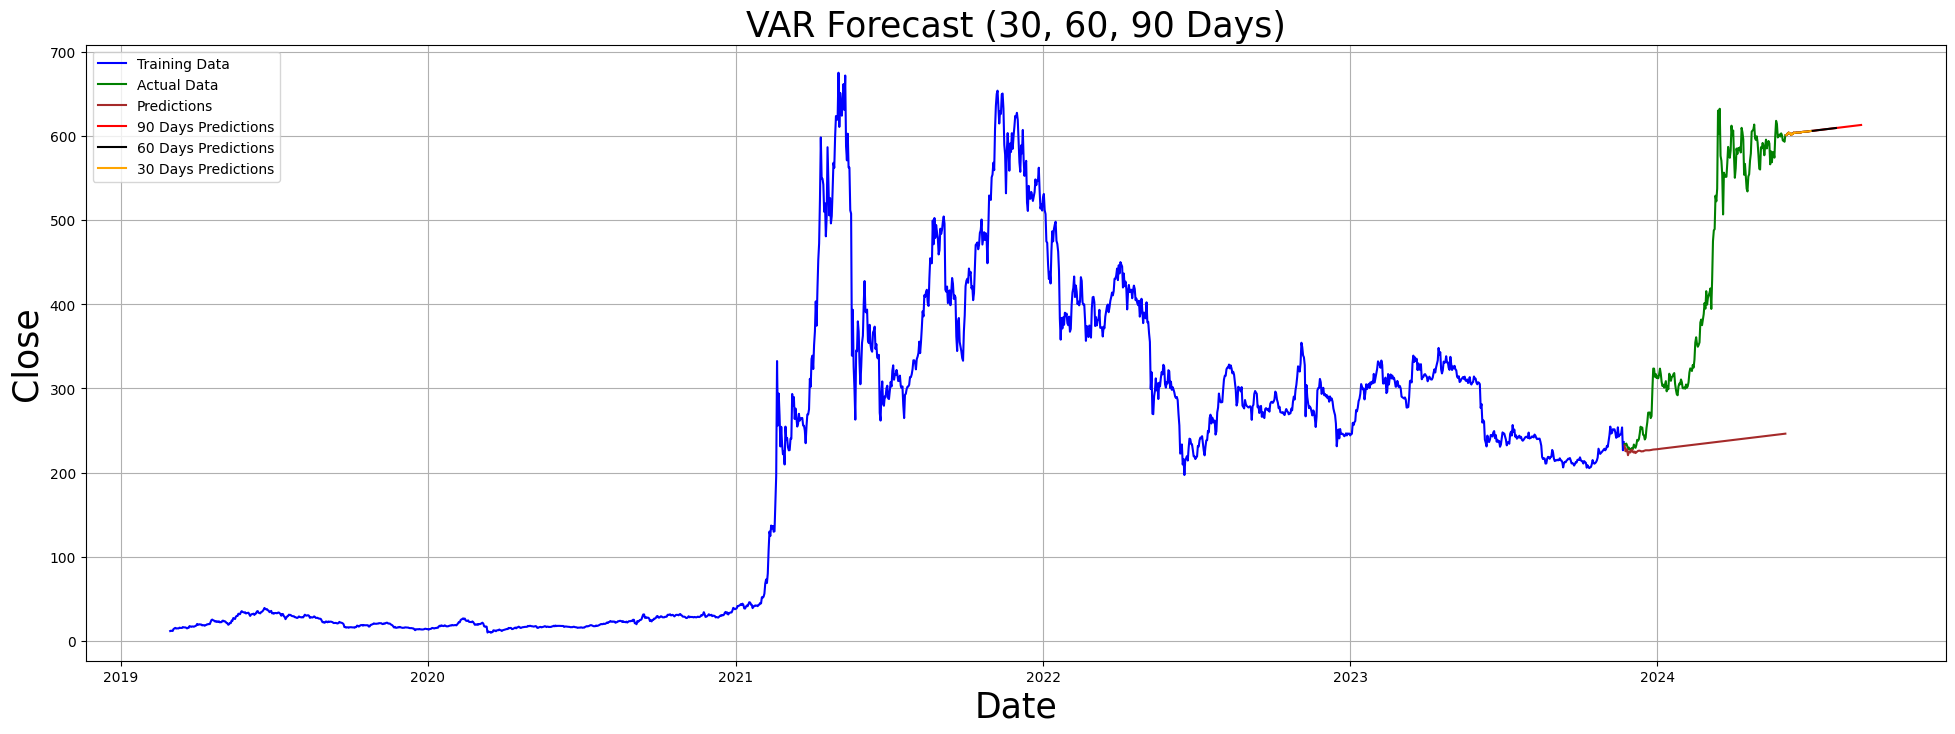

In [396]:
import matplotlib.pyplot as plt

# Assuming df_results_30days, df_results_60days, df_results_90days are your DataFrames containing forecast results
# Define the date range for plotting
start_date = '2019-01-03'
end_date = '2024-08-30'

# Plotting the data
plt.figure(figsize=(24, 8))

# Plotting the training data
plt.plot(train_data.index, train_data.Close, label='Training Data', color='blue')

# Plotting the actual test data
plt.plot(test_data.index, test_data.Close, label='Actual Data', color='green')
# Plotting the prediction data
plt.plot(test_data.index, df_results.Close_forecast, label='Predictions', color ='brown')
# Plotting the forecast results

plt.plot(df_results_90days.index, df_results_90days.Close_forecast, label='90 Days Predictions', color='red')

plt.plot(df_results_60days.index, df_results_60days.Close_forecast, label='60 Days Predictions', color='black')
plt.plot(df_results_30days.index, df_results_30days.Close_forecast, label='30 Days Predictions', color='orange')
# Adding title and labels
plt.title('VAR Forecast (30, 60, 90 Days)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Close', fontsize=25)

# Adding legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [399]:
y_test = test_data.Close
y_pred = df_results.Close_forecast

In [400]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



test_91_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_91_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_91_mse = np.mean((np.array(y_test) - np.array(y_pred))**2)
print('Testing RMSE:', test_91_rmse)
print('Testing MAPE:', test_91_mape)
print('Testing MSE:', test_91_mse)

Testing RMSE: 237.43901800564055
Testing MAPE: 38.65908835921566
Testing MSE: 56377.28727148289
